In [15]:
import sys
sys.path.append('/lustre/project/Stat/s1155077016/SGCAST/SGCAST/SGCAST')
from utils.utils import refine
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score



In [16]:
ARIset=[]
ID = '151673'
base_path = '/lustre/project/Stat/s1155077016/SGCAST/SGCAST/SGCAST/output'


file_name = "/lustre/project/Stat/s1155077016/spatial_data/"+ID+"/"+ID+".h5ad"
adata = sc.read_h5ad(file_name)

spots_embeddings = np.loadtxt(os.path.join(base_path, ID+'_embeddings.txt'))
adata.obsm['embedding'] = np.float32(spots_embeddings)
random_seed=2022
np.random.seed(random_seed)
os.environ['R_HOME'] = "/lustre/project/Stat/s1155077016/condaenvs/Seurat4/lib/R"
os.environ['R_USER'] = '/users/s1155077016/anaconda3/lib/python3.9/site-packages/rpy2'
import rpy2.robjects as robjects

robjects.r.library("mclust")

import rpy2.robjects.numpy2ri

rpy2.robjects.numpy2ri.activate()
r_random_seed = robjects.r['set.seed']
r_random_seed(random_seed)
rmclust = robjects.r['Mclust']
num_cluster = 7; modelNames="EEE" #adata.X[:,~np.all(adata.X == 0, axis = 0)]
res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm['embedding']), num_cluster, modelNames) 
mclust_res = np.array(res[-2])

adata.obs['mclust'] = mclust_res
adata.obs['mclust'] = adata.obs['mclust'].astype('int')
adata.obs['mclust'] = adata.obs['mclust'].astype('category')


obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df["Ground Truth"])
ARI




fitting ...
  |======================================================================| 100%


0.5664245806931019

In [17]:
from scipy.spatial.distance import cdist
xarr=np.array([adata.obs['array_row'].tolist()]).T
yarr=np.array([adata.obs['array_col'].tolist()]).T
am = np.concatenate((xarr,yarr), 1)
arr = cdist(am, am)

refined_pred=refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["mclust"].tolist(), dis=arr, shape="hexagon")
adata.obs["refined_pred"]=refined_pred
adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')

adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')
obs_df = adata.obs.dropna()
ARI_ref = adjusted_rand_score(obs_df['refined_pred'], obs_df["Ground Truth"])
ARI_ref

0.5992191222387968

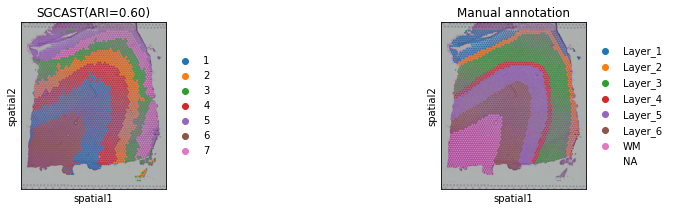

In [18]:
ARIset.append(ARI_ref)
plt.rcParams["figure.figsize"] = (6, 3)
   
sc.pl.spatial(adata, color=["refined_pred", "Ground Truth"], title=['SGCAST(ARI=%.2f)' % ARI_ref,
                                                                        "Manual annotation"])  # adata.obs["true"] = adata_processed.obs["true"]
 




In [19]:
print('ARI SET: ', ARIset)

ARI SET:  [0.5992191222387968]
